### Настройка Airflow

Для начала вам необходимо выполнить ряд команд чтобы настроить окружение для дальнейшей работы, это позволит первое время не заниматься настройкой среды исполнения, а сразу начать писать код и работать с Airflow.

In [ ]:
# Установка Airflow
!pip install "apache-airflow[telegram]==2.1.4" --constraint "https://raw.githubusercontent.com/apache/airflow/constraints-2.1.4/constraints-3.7.txt"

# Инициализация базы данных
!airflow db init

In [ ]:
# Создадим необходимые папки
!mkdir /root/airflow/dags
!touch /root/airflow/dags/dag.py

In [ ]:
# Включим веб-сервер
!airflow webserver -p 18273 -D

In [ ]:
# Создадим пользователя Airflow
!airflow users create \
          --username admin \
          --firstname admin \
          --lastname admin \
          --role Admin \
          --email admin@example.org \
          -p 12345

In [ ]:
# Запуск шедулера
!airflow scheduler -D

In [ ]:
# Последующие команды не имеют отношения к Airflow
# Они нужни только для корректной работы веб морды
# в среде Google Colab

!pip install pyngrok
!ngrok authtoken  # найти его можно https://dashboard.ngrok.com/get-started/setup

# Эта команда просто отображет веб морду на другой адрес
# Его вы можете найти https://dashboard.ngrok.com/cloud-edge/status
# При каждом отключении ссылка будет меняться
!nohup ngrok http 18273 > /dev/null &

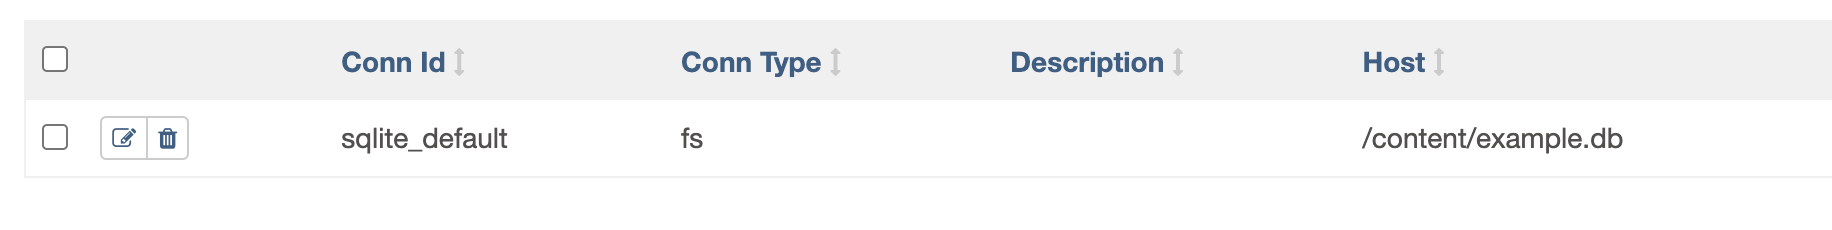

После запуска команды выше, перейдите по адресу в ngrok и подождите  пока появится DAG с именем dag

In [ ]:
# Pipeline: два оператора собирают данные, один сохраняет их в базу данных, а другой передает через Xcom. 
# Данные объединяются с помощью SQL-запроса и Jinja-шаблона

from airflow import DAG
from datetime import timedelta
from airflow.utils.dates import days_ago
from airflow.operators.python import PythonOperator
from airflow.providers.sqlite.operators.sqlite import SqliteOperator
from datetime import datetime

import pandas as pd
import sqlite3
import requests
import io

CONN = sqlite3.connect('/content/example.db')


# Создаем даг который создаст таблицу, запускаем один раз
dag_create_table= DAG(
    dag_id='dag_create_table',
    schedule_interval='@once',
    start_date=datetime(2022, 1, 26),
)

# Задача для создания таблицы в sqlite базе данных
create_table_data = SqliteOperator(
    task_id='create_table_data',
    sql="""CREATE TABLE join_data(
      currency TEXT,
      value INTEGER,
      date DATE,
      rate FLOAT
      )
    """,
    dag=dag_create_table,
)

# Даг который скачивает и объединяет данные
dag = DAG('dag',
          start_date=datetime(2021, 1, 1),
          end_date=datetime(2021, 1, 4),
          max_active_runs=1)

def extract_currency(date, **kwargs):
  url = f'https://api.exchangerate.host/timeseries?start_date={date}&end_date={date}&base=EUR&symbols=USD&format=csv'
  response = requests.get(url).content
  data = pd.read_csv(io.StringIO(response.decode('utf-8')))

  kwargs['ti'].xcom_push(key='return_value', value=data['rate'].values[0].replace(',','.'))


def insert_to_db(data, table_name, conn):
  data.to_sql(table_name, conn, if_exists='append', index=False)

def extract_data(date, conn):
  url = f'https://raw.githubusercontent.com/dm-novikov/stepik_airflow_course/main/data_new/{date}.csv'
  data = pd.read_csv(url,index_col=False)

  insert_to_db(data, 'data', conn)


read_csv_file_1 = PythonOperator(task_id='read_currency',
                      python_callable=extract_currency,
                      op_kwargs={'date': '{{ ds }}'},
                      dag=dag)


read_csv_file_2 = PythonOperator(task_id='read_data',
                      python_callable=extract_data,
                      op_kwargs={'date': '{{ ds }}', 'conn': CONN},
                      dag=dag)


join_data= SqliteOperator(
    task_id='join_data',
    sql="""INSERT INTO join_data(currency, value, date, rate) select currency, value, date, {{ti.xcom_pull(key='return_value')}} from data;""",
    dag=dag,
)

[read_csv_file_1, read_csv_file_2] >> join_data

[2023-04-26 18:42:36,076] {utils.py:160} INFO - NumExpr defaulting to 2 threads.


<Task(SqliteOperator): join_data>

In [ ]:
# чтобы првоерить решение можете обратиться к вашей базе данных таким образом
%load_ext sql
%config SqlMagic.feedback=False
%config SqlMagic.autopandas=True
%sql sqlite:////content/example.db
%sql select * from join_data

The sql extension is already loaded. To reload it, use:
  %reload_ext sql
 * sqlite:////content/example.db


,currency,value,date,rate
0,EUR,38,2021-01-01,1.217582
1,EUR,65,2021-01-01,1.217582
2,EUR,74,2021-01-01,1.217582
3,EUR,42,2021-01-01,1.217582
4,EUR,23,2021-01-01,1.217582
...,...,...,...,...
139,EUR,57,2021-01-04,1.225061
140,EUR,39,2021-01-04,1.225061
141,EUR,51,2021-01-04,1.225061
142,EUR,33,2021-01-04,1.225061


In [ ]:
# чтобы првоерить решение можете обратиться к вашей базе данных таким образом
%load_ext sql
%config SqlMagic.feedback=False
%config SqlMagic.autopandas=True
%sql sqlite:////content/example.db
%sql select * from data

The sql extension is already loaded. To reload it, use:
  %reload_ext sql
 * sqlite:////content/example.db


,currency,value,date
0,EUR,38,2021-01-01
1,EUR,65,2021-01-01
2,EUR,74,2021-01-01
3,EUR,42,2021-01-01
4,EUR,23,2021-01-01
5,EUR,48,2021-01-01
6,EUR,86,2021-01-01
7,EUR,74,2021-01-01
8,EUR,24,2021-01-01
9,EUR,27,2021-01-02


Даг нужно написать в файл /root/airflow/dags/dag.py. Проверку можно сделать в веб интерфейсе. Прежде чем даг появится, может пройти ~ 2-3 минут.